# pyFFTLog developing

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import pure python version; https://github.com/prisae/pyfftlog
import pyfftlog 

# Import pure f2py version; https://github.com/prisae/fftlog
import fftlog

# Import scipy implementation; scipy/scipy/fftpack> python setup.py install
from fftpack import rfftl, rfht

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 16})

## 1. FFTLog

In [2]:
# Range of periodic interval
logrmin = -6
logrmax = 6

# Number of points (Max 4096)
n = 256

# Order mu of Bessel function
mu = 0

# Bias exponent: q = 0 is unbiased
q = 0

# Sensible approximate choice of k_c r_c
kr = 1
kropt = 0

# Forward transform (changed from dir to tdir, as dir is a python fct)
tdir = 1

# Central point log10(r_c) of periodic interval
logrc = (logrmin + logrmax)/2

# Central index (1/2 integral if n is even)
nc = (n + 1)/2.0

# Log-spacing of points
dlogr = (logrmax - logrmin)/n
dlnr = dlogr*np.log(10.0)

r = 10**(logrc + (np.arange(1, n+1) - nc)*dlogr)
ar = r**(mu + 1)*np.exp(-r**2/2.0)

# logrmin=-logrmax, kr=1, kropt=0 => r = k
k = r
rk = kr
theo = k**(mu + 1)*np.exp(-k**2/2.0)

### Calculate

The run times depend a lot on the size of the array. However, in all my tests `scipy` was fastest. Depending on array-size, `f2py` or `python` is the slowest.

In [16]:
# 1. f2py
_, wsavef2py, _ = fftlog.fhti(n, mu, dlnr, q, kr, kropt)
out1 = %timeit -q -o fftlog.fhti(n, mu, dlnr, kr, q, kropt)
akf2py = fftlog.fht(ar.copy(), wsavef2py, tdir)
out2 = %timeit -q -o fftlog.fht(ar.copy(), wsavef2py, 1)
print(u'f2py   :: %10.3f ms :: ' % (1000*(out1.best+out2.best)))

# 2. Pure Python
_, wsavepp = pyfftlog.fhti(n, mu, dlnr, q, kr, kropt)
out3 = %timeit -q -o pyfftlog.fhti(n, mu, dlnr, q, kr, kropt)
akpp = pyfftlog.fht(ar.copy(), wsavepp, 1)
out4 = %timeit -q -o pyfftlog.fht(ar.copy(), wsavepp, 1)
print(u'python :: %10.3f ms :: ' % (1000*(out3.best+out4.best)))

# 3. scipy-implementation
akscipy = rfht(ar.copy(), dlnr, mu, q, kr, kropt)
out5 = %timeit -q -o rfht(ar.copy(), dlnr, mu, q, kr, kropt)
print(u'scipy  :: %10.3f ms :: ' % (1000*out5.best))

f2py   ::      0.066 ms :: 
python ::      0.092 ms :: 
scipy  ::      0.038 ms :: 


### Plot

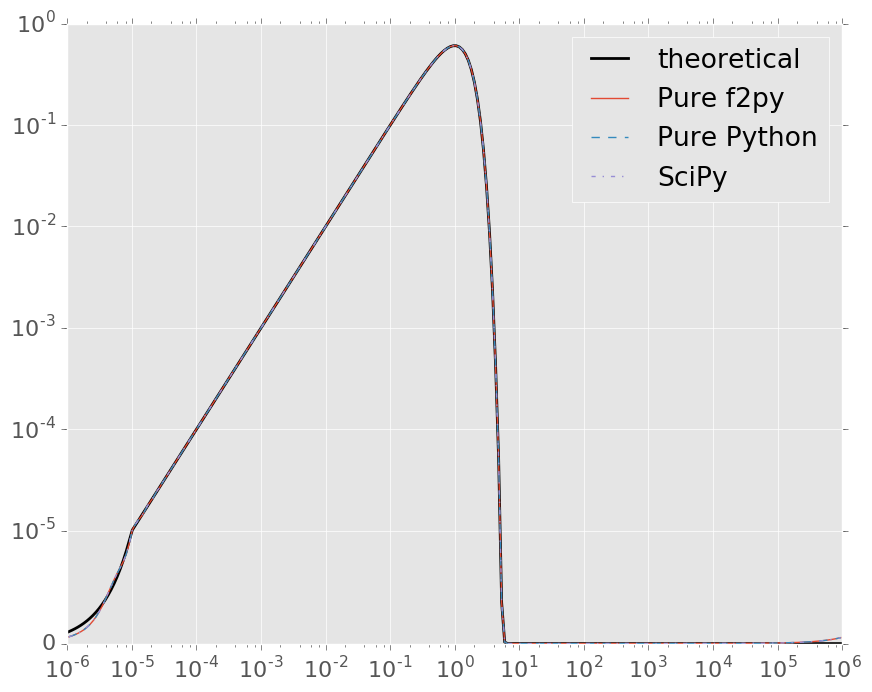

In [13]:
plt.figure(figsize=(10,8))
plt.plot(k, theo, 'k-', lw=2, label='theoretical')
plt.plot(k, akf2py, '-', label='Pure f2py')
plt.plot(k, akpp, '--', label='Pure Python')
plt.plot(k, akscipy, '-.', label='SciPy')
plt.xscale('log')
plt.yscale('symlog', basey=10, linthreshy=1e-5)
plt.legend(loc='best')
plt.show()